### Install TensorFlow and TensorFlow Model Garden

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.7.0


In [ ]:
!pip install -q tensorflow==2.3.0

     |████████████████████████████████| 320.4 MB 52 kB/s 
     |████████████████████████████████| 20.1 MB 1.4 MB/s 
     |████████████████████████████████| 2.9 MB 32.9 MB/s 
     |████████████████████████████████| 459 kB 41.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 506), reused 1388 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 27.32 MiB/s, done.
Resolving deltas: 100% (506/506), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

Download and Import the Quora Insincere Questions Dataset

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.3.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df=pd.read_csv("https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip",compression='zip',low_memory=False)
df.shape

(1306122, 3)

In [ ]:
df.head(20)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


<AxesSubplot:title={'center':'Taregt distribution'}, ylabel='Frequency'>

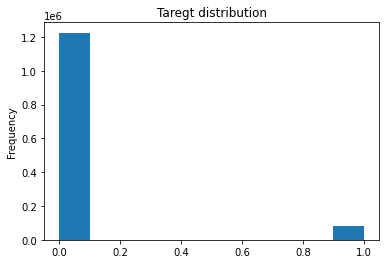

In [ ]:
df.target.plot(kind='hist',title='Taregt distribution')

Create tf.data.Datasets for Training and Evaluation

In [ ]:
train_df,remaining=train_test_split(df,random_state=42,train_size=0.0075,stratify=df.target.values)
valid_df,_=train_test_split(remaining,random_state=42,train_size=0.00075,stratify=remaining.target.values)
train_df.shape,valid_df.shape

((9795, 3), (972, 3))

In [ ]:
with tf.device('/cpu:0'):
  train_data=tf.data.Dataset.from_tensor_slices((train_df['question_text'].values,train_df['target'].values))
  valid_data=tf.data.Dataset.from_tensor_slices((valid_df.question_text.values,valid_df.target.values))  
  for text,label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


Download a Pre-trained BERT Model from TensorFlow Hub

In [ ]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""
label_list=[0,1]
max_seq_length=128
train_batch_size=32
 # Label categories
 # maximum length of (token) input sequences
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",trainable=True)
vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case=bert_layer.resolved_object.do_lower_case.numpy()
tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case)


# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2



Tokenize and Preprocess Text for BERT

We'll need to transform our data into a format BERT understands.

In [ ]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example=classifier_data_lib.InputExample(guid=None,text_a=text.numpy(),text_b=None,label=label.numpy())
  feature=classifier_data_lib.convert_single_example(0,example,label_list,max_seq_length,tokenizer)
  return (feature.input_ids,feature.input_mask,feature.segment_ids,feature.label_id)
  
  

Wrap a Python Function into a TensorFlow op for Eager Execution

In [ ]:
def to_feature_map(text, label):
  input_ids,input_mask,segment_ids,label_id=tf.py_function(to_feature,inp=[text,label],Tout=[tf.int32,tf.int32,tf.int32,tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x={'input_word_ids':input_ids,'input_mask':input_mask,'input_type_ids':segment_ids}
  return (x,label_id)
  
  

Create a TensorFlow Input Pipeline with `tf.data`

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data=(train_data.map(to_feature_map,num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(1000).batch(32,drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))
  # valid
  valid_data=(valid_data.map(to_feature_map,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32,drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))
  
  

The resulting `tf.data.Datasets` return `(features, labels)` pairs

In [ ]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

Add a Classification Head to the BERT Layer

In [ ]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")
  

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop=tf.keras.layers.Dropout(0.4)(pooled_output)
  output=tf.keras.layers.Dense(1,activation='sigmoid',name="output")(drop)

  model=tf.keras.Model(
      inputs={'input_word_ids':input_word_ids,
      'input_mask':input_mask,
      'input_type_ids':input_type_ids
      },
      outputs=output
  )
  return model
  

Fine-Tune BERT for Text Classification

In [ ]:
model=create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),loss=tf.keras.losses.BinaryCrossentropy(),metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

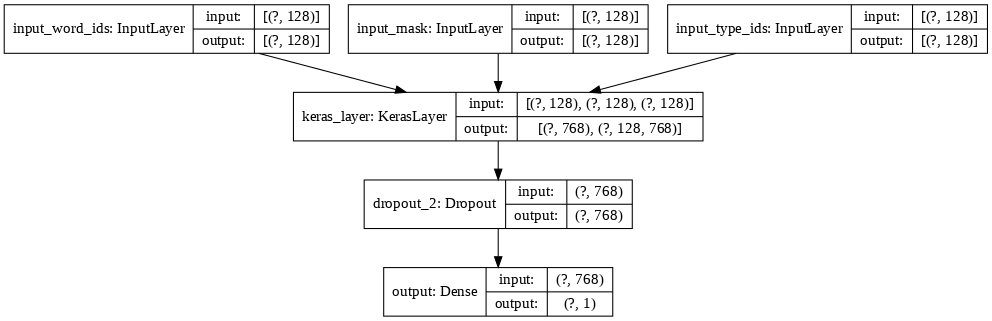

In [ ]:
tf.keras.utils.plot_model(model=model,show_shapes=True,dpi=76)

In [ ]:
# Train model
epochs=4
history=model.fit(train_data,validation_data=valid_data,epochs=epochs,verbose=1)

Epoch 1/4
306/306 [==============================] - ETA: 0s - loss: 0.1698 - binary_accuracy: 0.9381WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0286s vs `on_test_batch_end` time: 0.5132s). Check your callbacks.


306/306 [==============================] - 494s 2s/step - loss: 0.1698 - binary_accuracy: 0.9381 - val_loss: 0.1252 - val_binary_accuracy: 0.9594
Epoch 2/4
306/306 [==============================] - 493s 2s/step - loss: 0.1025 - binary_accuracy: 0.9601 - val_loss: 0.1340 - val_binary_accuracy: 0.9552
Epoch 3/4
306/306 [==============================] - 493s 2s/step - loss: 0.0535 - binary_accuracy: 0.9810 - val_loss: 0.1756 - val_binary_accuracy: 0.9458
Epoch 4/4
306/306 [==============================] - 493s 2s/step - loss: 0.0259 - binary_accuracy: 0.9912 - val_loss: 0.1986 - val_binary_accuracy: 0.9542


Evaluate the BERT Text Classification Model

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

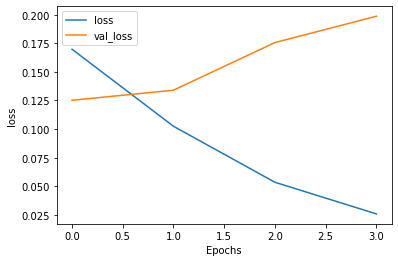

In [ ]:
plot_graphs(history,'loss')

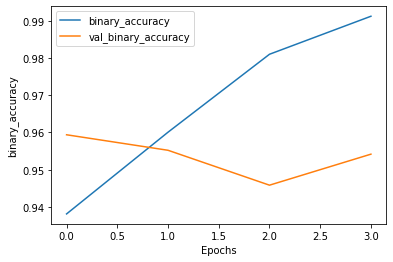

In [ ]:
plot_graphs(history,'binary_accuracy')